# Project Argus

This part of the project is focused on the use of machine learning for the selection of the study machines needed by the analyst. 

In [1]:
# Firt we import some libraries. 

from Scripts.datosadash import datosADASH
import pandas as pd
import itertools
import datetime
import numpy as np
pd.set_option('display.max_columns', None)

In [5]:
# To get all files extracted from vibration analysis software we have created the module "datosADASH".
# The software export a csv file for every measurement. 

# Before importation we must set the path; you must select the path were yout data is:
path = '/Volumes/TOSHIBA EXT/Export'

# And create an datosAdash object with path as parameter.
folder = datosADASH(path)

In [6]:
# Next we get the name of files, machines and points with methods of "datosADASH" module.
# getmachines return 

machines = folder.getmachines()
points = folder.getpoints()
files = folder.getfiles()

In [7]:
print("\nDATA SUMMARY")
print("===============================")
print("We have a total of {} machines".format(len(machines)))
print("We have a total of {} points".format(sum([len(points[x]) for x in points])))
print("We have a total of {} files".format(len(files)))
print("===============================")



DATA SUMMARY
We have a total of 192 machines
We have a total of 1920 points
We have a total of 60722 files


## Data import and cleaning

Now we have a list of machines, points and files we are going to import and clean. We are going to iterate in the dynamic mesurements to obtein revelant information. We have a total of 48510 files, so we may need to optimize data extraction. In our case we will use a Multiprocess method to reduce import time.

In [8]:
# Now we iterate for every file and get the data we need. Due the structure of .csv files
# we get raw data first and the date from the first line fo the file.

'''from Scripts.waveform import Waveform, Raw_Waveform_Date
from Scripts.spectrum import Spectrum


waveform_parameters = []'''

df_mms_params = pd.DataFrame(columns=['machine','point','time','max_mms','rms_mms'])
df_acc_params = pd.DataFrame(columns=['machine','point','time','max_acc',
                                      'med_acc','rms_acc', 'kur_acc', 'cf_acc'])
df_dem_params = pd.DataFrame(columns=['machine','point','time','max_dem','rms_dem'])
df_spec_acc_params = pd.DataFrame(columns=['machine','point','time','num_peaks',
                                          'a_range','b_range', 'c_range','d_range',
                                          'e_range','f_range','g_range','h_range',
                                          'i_range','j_range'])

df_mms_params.to_csv('Data/mms_params.csv', index=False)
df_acc_params.to_csv('Data/acc_params.csv', index=False)
df_dem_params.to_csv('Data/dem_params.csv', index=False)
df_spec_acc_params.to_csv('Data/spec_acc_params.csv', index=False)

# To identify the type of measurement we must copy
# the point definition in ADASH Software
vel_time_text = "Velocidad - Forma de onda"
acc_time_text = "Aceleracion - Forma de onda"
demod_time_text = "Demodulacion - Forma de onda"
acc_spec_text = "Aceleracion - Espectro"

In [6]:
# Secuencual solution. With this solution Wall Time is about
# 26 minutes. Too much time for a coffe, we just left the
# the code for informative propurse

"""
%%time



for machine, points_iter in points.items():
    filteredmachines = list(filter(lambda x: machine in x, files))
    for iteration, point in enumerate(points_iter):
        # Get the files for every point        
        filteredpoints = list(filter(lambda x: point in x, filteredmachines))
        filteredcsv = list(filter(lambda x:".csv" in x, filteredpoints))
        
        # Get files by type of measurement
        veltime = list(filter(lambda x:vel_time_text in x, filteredcsv))
        acctime = list(filter(lambda x:acc_time_text in x, filteredcsv))
        demodtime = list(filter(lambda x:demod_time_text in x, filteredcsv))
        accspec = list(filter(lambda x:acc_spec_text in x, filteredcsv))
        
        
        # Get mms parameters for analysis
        for filetime in veltime:
            
            # We use Raw_Waveform_Date model to get
            # column with waveform data and date
            # measurement
            raw_data = Raw_Waveform_Date(filetime)
            column_vel = raw_data.get_raw_data()
            date_df_time = raw_data.get_datetime()         

            # Now we use get_mm_params method to get useful 
            # features of raw signal
            calculated_params = Waveform(column_vel).get_mms_params()
            
            # Creation of a row to be append in the dataframe
            time_mms_row = {'machine':machine, 'point':point, 'max_mms':calculated_params[0],
                       'rms_mms':calculated_params[1], 'time':date_df_time}
            
            
            df_mms_params = df_mms_params.append(time_mms_row, ignore_index=True)
        
        
        
        # Get acceleration params. Same procedure as mms, but
        # we use get_acc_params method wich return parameters
        # associated with acceleration
        for filetime in acctime:
            
            raw_data = Raw_Waveform_Date(filetime)
            column_vel = raw_data.get_raw_data()
            date_df_time = raw_data.get_datetime()
            
            calculated_params = Waveform(column_vel).get_acc_params()
            
            time_acc_rows = {'machine':machine, 'point':point, 'max_acc':calculated_params[0],
                       'med_acc':calculated_params[1], 'rms_acc':calculated_params[2],
                        'kur_acc':calculated_params[3], 'cf_acc':calculated_params[4],
                        'time':date_df_time}
            
            df_acc_params = df_acc_params.append(time_acc_rows, ignore_index=True)
            
            
        # Get demomd params. Mostly the same than mm/s
        # params                
        for filetime in demodtime:
            
            raw_data = Raw_Waveform_Date(filetime)
            column_vel = raw_data.get_raw_data()
            date_df_time = raw_data.get_datetime()
            
            calculated_params = Waveform(column_vel).get_demod_params()
            
            time_demod_rows = {'machine':machine, 'point':point, 'max_dem':calculated_params[0],
                               'rms_dem':calculated_params[1],  'time':date_df_time}
            
            df_dem_params = df_dem_params.append(time_demod_rows, ignore_index=True)
            
            

       
        # Get spectrum params. In spectrum is important
        # peaks that are excitated. The number of peaks is
        # associated with damage severity.
        for filespec in accspec:
            spectrum_data = Spectrum(filespec) 
            date_df_spec = spectrum_data.get_datetime()
            peaks, calculated_params, a_range, b_range, c_range, d_range, e_range, f_range, \
            g_range, h_range, i_range, j_range = spectrum_data.get_spec_params()
            
            spec_acc_row = {'machine':machine, 'point':point,
                            'num_peaks': float(len(peaks)), 'peaks':peaks,
                            'time':date_df_spec, 'a_range':a_range, 'b_range':b_range, 
                            'c_range':c_range, 'd_range':d_range, 'e_range':e_range,
                            'f_range':f_range, 'g_range':g_range, 'h_range':h_range,
                            'i_range':i_range, 'j_range':j_range}            
            
            
            df_spec_acc_params = df_spec_acc_params.append(spec_acc_row, ignore_index=True)
"""
print("")

In [9]:
%%time
# MultiProcess approach. Using multiprocessing library we can create multiple
# processes to reduce time due to data reading.

from multiprocessing import Process
from Scripts.get_values import get_values
import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
import time

processes = []       


machines_split = np.array_split(machines, 5)
len(machines_split)

if __name__ == '__main__':

    for index in range(len(machines_split)):
    # We start one thread per file present.
        print("Starting index {} - Number of machines {}".format(index, len(machines_split[index])))
        logging.info("[P{}]\tStartin index".format(index))
        process = Process(target=get_values, args=[index, machines_split[index], points,
                                                   files, df_mms_params, df_acc_params,
                                                   df_dem_params, df_spec_acc_params])

        processes.append(process)
        process.start()

    # We now pause execution on the main thread by 'joining' all of our started threads.
    # This ensures that each has finished processing.
    for process in processes:
        process.join()

Starting index 0 - Number of machines 39
Starting index 1 - Number of machines 39
Starting index 2 - Number of machines 38
Starting index 3 - Number of machines 38
Starting index 4 - Number of machines 38
CPU times: user 72.1 ms, sys: 124 ms, total: 197 ms
Wall time: 7min 10s


In [10]:
#Now we load the created csv from files

df_mms_params = pd.read_csv('Data/mms_params.csv')
df_acc_params = pd.read_csv('Data/acc_params.csv')
df_dem_params = pd.read_csv('Data/dem_params.csv')
df_spec_acc_params = pd.read_csv('Data/spec_acc_params.csv')

In [11]:
# Now we check all dataframes returns the same
# numbers of machines

print("MACHINES IN FILES")
print("==================================")
print("File with mms params: {} machines".format(len(df_mms_params.machine.unique())))
print("File with acc params: {} machines".format(len(df_acc_params.machine.unique())))
print("File with demod params: {} machines".format(len(df_dem_params.machine.unique())))
print("File with acc spectrum params: {} machines".format(len(df_spec_acc_params.machine.unique())))
print("==================================")

MACHINES IN FILES
File with mms params: 192 machines
File with acc params: 192 machines
File with demod params: 192 machines
File with acc spectrum params: 192 machines


In [12]:
# If something goes wrong we only keep rows where machine
# column value is in the list of machines

df_dem_params = df_dem_params[df_dem_params['machine'].isin(machines)]
df_spec_acc_params = df_spec_acc_params[df_spec_acc_params['machine'].isin(machines)]
df_mms_params = df_mms_params[df_mms_params['machine'].isin(machines)]
df_acc_params = df_acc_params[df_acc_params['machine'].isin(machines)]

In [13]:
# We need sort the dataframes by time and set it as index

def sorted_index_by_time(df):
    """Function for sorting values
    by time and set it to index"""
    df = df.sort_values(['time'])
    df['time'] = pd.to_datetime(df['time'])
    return df

df_mms_params_sorted = sorted_index_by_time(df_mms_params)
df_acc_params_sorted = sorted_index_by_time(df_acc_params)
df_dem_params_sorted = sorted_index_by_time(df_dem_params)
df_spec_acc_params_sorted = sorted_index_by_time(df_spec_acc_params)

In [14]:
# In this step we merge dataframes on time using merge_asof because maybe
# timestamp does not fit perfectly, so merge_asof search for the
# nearest timestamp

merged = pd.merge_asof(df_mms_params_sorted, df_acc_params_sorted, on="time", by=['machine', 'point'])
merged = pd.merge_asof(merged, df_spec_acc_params_sorted, on="time", by=['machine', 'point'])
merged = pd.merge_asof(merged, df_dem_params_sorted, on="time", by=['machine', 'point'])

# After that we set all frequency range as float

for col in ['c_range', 'd_range', 'e_range',
      'e_range', 'g_range', 'h_range',
      'i_range', 'i_range']:
    merged[col] = merged[col].astype('float64')

In [15]:
# Now the dataframe has the columns:    
merged.columns

Index(['machine', 'point', 'time', 'max_mms', 'rms_mms', 'max_acc', 'med_acc',
       'rms_acc', 'kur_acc', 'cf_acc', 'num_peaks', 'a_range', 'b_range',
       'c_range', 'd_range', 'e_range', 'f_range', 'g_range', 'h_range',
       'i_range', 'j_range', 'max_dem', 'rms_dem'],
      dtype='object')

In [16]:
# For prediction we will need to get measurements
# made in 2021

merged_2021 = merged[merged.time.dt.year == 2021]
merged_2021.to_csv('Data/diagnosis_2021.csv')

## Labeling

For get labels we use the diagnostic made by the analyst. We have exported data from sql database were reports are stored to csv file. To read csv files, due to names of machines in SQL database are different than names in vibration software DB, we need to load a csv with the relation between these names. After that we merge the diagnostics with the previous dataframe.

We have two DB because in 2020 we upgraded the software where reports are generated and DB was also modified.

In [17]:
# Data from legacy DB.
diagnosis = pd.read_csv('Data/diagnosticos_secaderos.csv', sep=",").sort_values('Fecha')
diagnosis.Fecha = pd.to_datetime(diagnosis.Fecha)
diagnosis = diagnosis.rename(columns={'Fecha':'time',
                                          'fnStripTags(HTML_UnEncode(an.Texto))':'diagnostico'})



# Data from current DB
diagnosis_new = pd.read_csv('Data/secaderos_new_2.csv', sep=",")
diagnosis_new[' Fecha']= pd.to_datetime(diagnosis_new[' Fecha'])
diagnosis_new = diagnosis_new.rename(columns={'Activo':'Nombre',
                                                  'Estado':'Id_Estado_Activo',
                                                  'Diagnóstico':'diagnostico',
                                                  ' Fecha':'time'})
diagnosis_new = diagnosis_new.drop(columns=['Recomendaciones'])

# In this exportation status of machines are labeled as "BUENO", "SEGUIMIENTO",
# and "ACTUACION". In order to fit with previous dataframe we need to map
# this values with a Id code
estados = {'BUENO':1,
          'SEGUIMIENTO':2,
          'ACTUACION':3}
diagnosis_new.Id_Estado_Activo = diagnosis_new.Id_Estado_Activo.map(estados)


# Now we can append the dataframes

diag_total = diagnosis.append(diagnosis_new, sort=False)


# In this step we load the csv to help us to relate names from SQL DB 
# and Vibration Software
usecols = ['Equipo_adash', 'Equipo_home']
names = pd.read_csv('Data/nombres_filt.csv', sep=',',  encoding = "ISO-8859-1", usecols=usecols)
names = names.rename(columns={"Equipo_adash":"machine", "Equipo_home":"Nombre"})



# Finally we merge the dataframes, taking care for differences
# in machine names between databases and also using merge_asof

diagnosis_mer = diag_total.merge(names, how="outer", on="Nombre")
dict_machines = {'S1-M1':'S1-M01', 'S1-M2':'S1-M02',
                'S1-M3':'S1-M03', 'S1-M5':'S1-M05',
                'S1-M6':'S1-M06', 'S1-M8':'S1-M08',
                'S1-M9':'S1-M09', 'S2-M1':'S2-M01',
                'S2-M2':'S2-M02', 'S2-M3':'S2-M03',
                'S2-M5':'S2-M05', 'S2-M6':'S2-M06',
                'S2-M8':'S2-M08', 'S2-M9':'S2-M09',
                'S3-M1':'S3-M01', 'S3-M2':'S3-M02',
                'S3-M3':'S3-M03', 'S3-M5':'S3-M05',
                'S3-M6':'S3-M06', 'S3-M8':'S3-M08',
                'S3-M9':'S3-M09'}
diagnosis_mer.machine = diagnosis_mer.machine.replace(dict_machines)
diagnosis_mer = diagnosis_mer.dropna()
diagnosis_mer = diagnosis_mer.sort_values('time')
diagnosis = pd.merge_asof(merged, diagnosis_mer, on="time", by=['machine'],
                  tolerance=pd.Timedelta('40 days'), direction='nearest')

diagnosis = diagnosis.dropna()

In [18]:
# Now we have a dataframe with all measurments with the
# features we considered important and the diagnosis 
# set by the analyst in the column "Id_Estado_Activo".
# We hace three labeles now:
# 1 - Good
# 2 - Warning
# 3 - Alarm


diagnosis.tail()

,machine,point,time,max_mms,rms_mms,max_acc,med_acc,rms_acc,kur_acc,cf_acc,num_peaks,a_range,b_range,c_range,d_range,e_range,f_range,g_range,h_range,i_range,j_range,max_dem,rms_dem,Nombre,diagnostico,Id_Estado_Activo
7012,S6-60-M1,V-LA-H,2020-10-15 12:18:05.724,7.8458,2.167343,1.80850,0.597647,0.451216,0.154898,4.008060,1.0,0.00000,0.0,0.0,0.0,0.08654,0.0,0.0,0.0,0.0,0.0,3.56690,1.557249,S6-Ventilador Extracción 60 M1,Motor: Activo en buen estado. ...,1.0
7013,S6-60-M1,V-LA-V,2020-10-15 12:18:15.614,38.1660,11.641700,1.93530,0.646648,0.520390,0.156159,3.718943,2.0,0.39522,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,3.85140,1.723659,S6-Ventilador Extracción 60 M1,Motor: Activo en buen estado. ...,1.0
7014,S6-60-M1,V-LOA-H,2020-10-15 12:18:26.963,10.1070,4.368269,1.14580,0.500272,0.314268,0.007161,3.645932,1.0,0.11015,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,1.76430,0.720538,S6-Ventilador Extracción 60 M1,Motor: Activo en buen estado. ...,1.0
7015,S6-60-M1,V-LOA-V,2020-10-15 12:18:37.104,12.6580,4.820854,1.37550,0.562478,0.394479,0.142640,3.486881,1.0,0.11296,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,1.47200,0.716472,S6-Ventilador Extracción 60 M1,Motor: Activo en buen estado. ...,1.0
7016,S6-60-M1,V-LOA-A,2020-10-15 12:18:48.354,11.0760,4.717231,0.90775,0.456387,0.256956,0.299284,3.532704,1.0,0.12036,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.96074,0.475749,S6-Ventilador Extracción 60 M1,Motor: Activo en buen estado. ...,1.0


The health of the equipment (motor+fan) is saved in a column in the database, and the detailed diganosis is saved in plain text just like that:

<table style="width:80%">
  <tr>
    <th>Diagnosis</th>
    <th>Status</th>
  </tr>
  <tr>
    <td>Motor: Activo en buen estado. <br>
        Ventilador: Activo en buen estado.
      </td>
    <td>Good</td>
  </tr>
  <tr>
    <td>Motor: Síntomas de degradación de 
        rodamientos. Seguimiento.<br>
        Ventilador: Activo en buen estado.
      </td>
    <td>Seguimiento</td>
  </tr>
</table>

In the second row Motor is diagnosed as 2 (Warning) and equipment status has labeled also has Warning, but the Fan status is ok. 
We must correct that to prevent an element in good health from being labeled as "warning" or "alert".

In [19]:
# We create a function to modify the label.

def texto_diagnostico(row):
    if '\n' in row['diagnostico']:
        texto_separado = row['diagnostico'].split('\n')
    else:
        texto_separado = row['diagnostico'].split('. ')
    buen = "buen"
    ventilador ="Ventilador"
    motor = "Motor"
    conjunto = "Conjunto"
    if len(texto_separado) > 1:
        if buen in texto_separado[0] and row['Id_Estado_Activo'] > 1 and row['point'].strip().startswith("M"):            
            valor_estado = 1
        if buen in texto_separado[1] and row['Id_Estado_Activo'] > 1 and row['point'].strip().startswith("V"):            
            valor_estado = 1
        else:
            valor_estado = row['Id_Estado_Activo']
    if len(texto_separado) == 1:        
        if ventilador in texto_separado[0] and row['point'].strip().startswith("V"):              
            valor_estado = row['Id_Estado_Activo']
        if motor in texto_separado[0] and row['point'].strip().startswith("M"):            
            valor_estado = row['Id_Estado_Activo']
        if conjunto in texto_separado[0]:
            valor_estado = row['Id_Estado_Activo']
        else:
            valor_estado = 1
    if row['max_mms'] > 10:
        valor_estado = 2
    if row['max_acc'] > 5:
        valor_estado = 2
    return valor_estado

In [20]:
# Now we use the function with apply method

diagnosis['Id_Estado_Activo_fixed'] = diagnosis.apply(lambda row: texto_diagnostico(row), axis=1)

# Data Checkpoint

In this point we create a copy of the main dataframe for avoid time consuming operations if something goes wrong in the future

In [21]:
diagnosis_cop = diagnosis.copy()

In [22]:
diagnosis_cop[['Nombre', 'diagnostico', 'Id_Estado_Activo_fixed', 'time', 'max_mms',
       'machine']].to_csv('diagnosis.csv')

In [23]:
# Lets take a look to the dataframe with the new column "Id_Estado_Activo_fixed" for a machine

diagnosis_cop[diagnosis_cop['machine']=='S5-61-M1'][['point','diagnostico','Id_Estado_Activo','Id_Estado_Activo_fixed']]

,point,diagnostico,Id_Estado_Activo,Id_Estado_Activo_fixed
143,M-LOA-H,Motor: Activo en buen estado. \n Ventilador: ...,1.0,2.0
144,M-LOA-V,Motor: Activo en buen estado. \n Ventilador: ...,1.0,2.0
145,M-LA-H,Motor: Activo en buen estado. \n Ventilador: ...,1.0,1.0
146,M-LA-V,Motor: Activo en buen estado. \n Ventilador: ...,1.0,2.0
147,M-LA-A,Motor: Activo en buen estado. \n Ventilador: ...,1.0,1.0
148,V-LA-H,Motor: Activo en buen estado. \n Ventilador: ...,1.0,1.0
149,V-LA-V,Motor: Activo en buen estado. \n Ventilador: ...,1.0,2.0
150,V-LOA-H,Motor: Activo en buen estado. \n Ventilador: ...,1.0,1.0
151,V-LOA-V,Motor: Activo en buen estado. \n Ventilador: ...,1.0,2.0
152,V-LOA-A,Motor: Activo en buen estado. \n Ventilador: ...,1.0,1.0


# Data Exploration CORREGIR

Now we explore data to identify data outlier or data insd

In [24]:
diagnosis_cop.columns

Index(['machine', 'point', 'time', 'max_mms', 'rms_mms', 'max_acc', 'med_acc',
       'rms_acc', 'kur_acc', 'cf_acc', 'num_peaks', 'a_range', 'b_range',
       'c_range', 'd_range', 'e_range', 'f_range', 'g_range', 'h_range',
       'i_range', 'j_range', 'max_dem', 'rms_dem', 'Nombre', 'diagnostico',
       'Id_Estado_Activo', 'Id_Estado_Activo_fixed'],
      dtype='object')

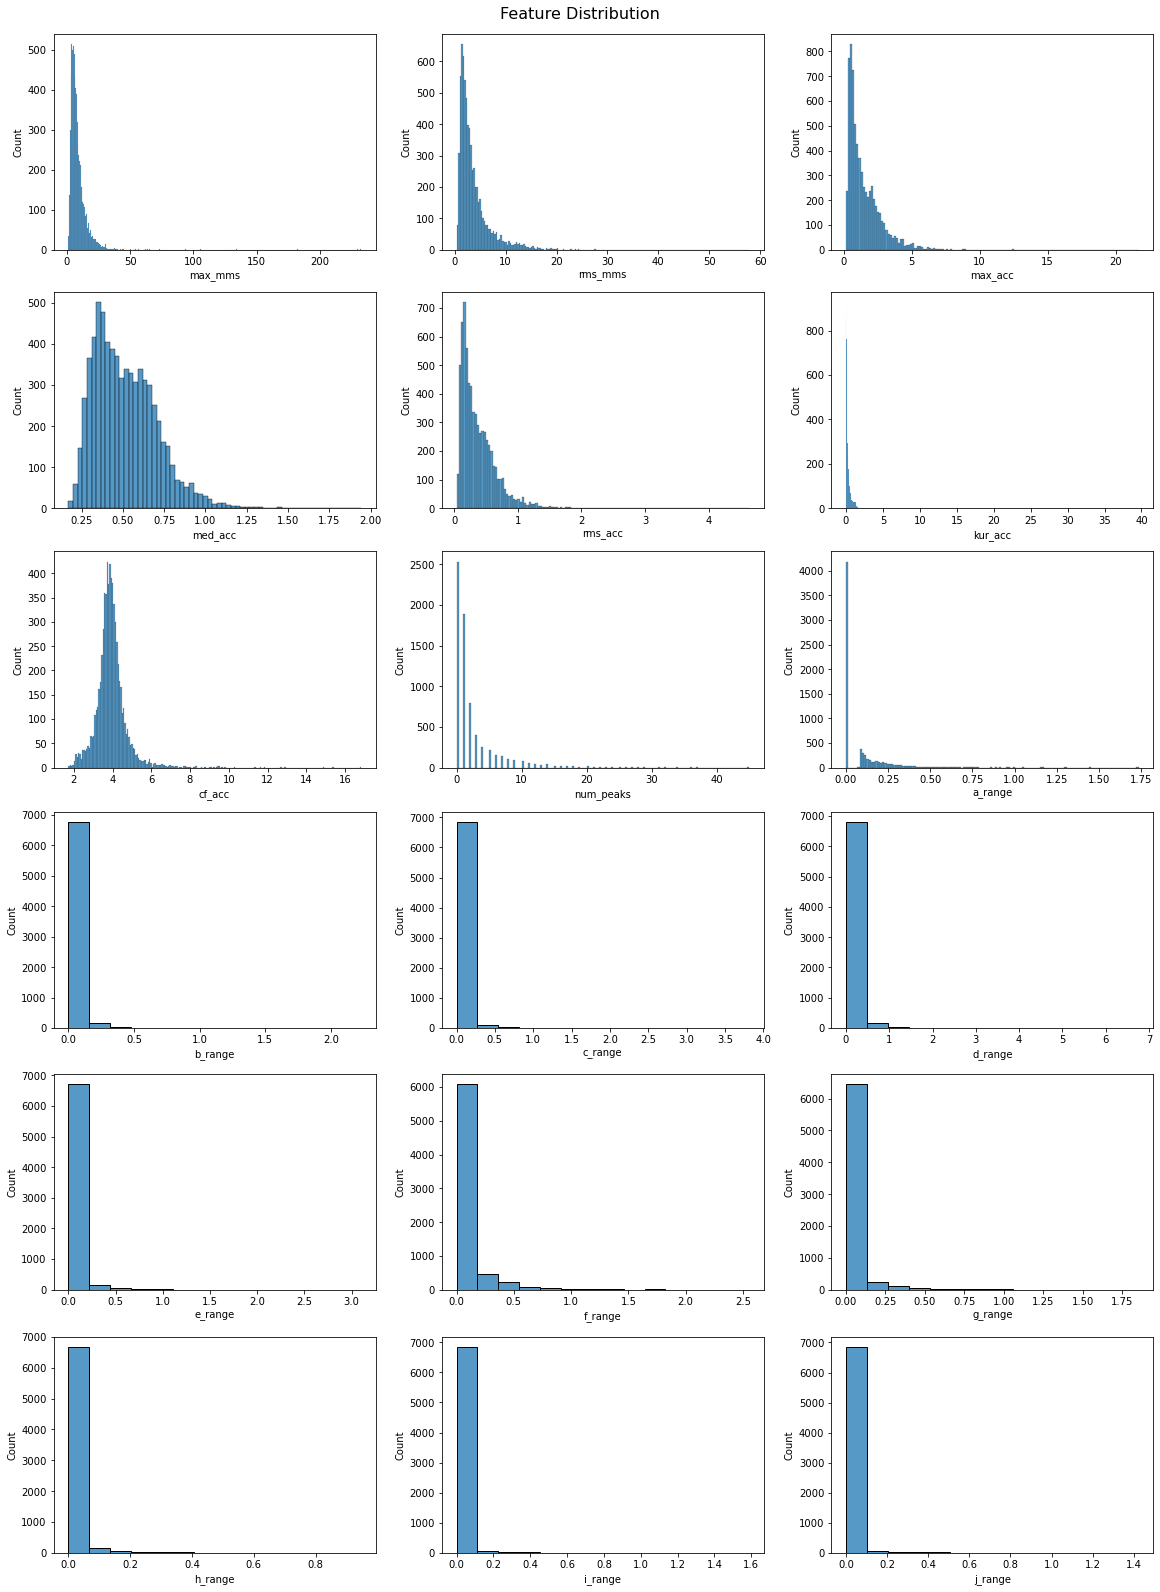

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axs = plt.subplots(ncols=3, nrows=6, figsize=(16,22), constrained_layout=True)

columns = ['max_mms', 'rms_mms', 'max_acc', 'med_acc',
       'rms_acc', 'kur_acc', 'cf_acc', 'num_peaks','a_range', 'b_range',
       'c_range','d_range', 'e_range', 'f_range', 'g_range', 'h_range',
       'i_range', 'j_range', 'max_dem', 'rms_dem',]

fig.suptitle('Feature Distribution', fontsize=16)
for index, value in enumerate(columns):
    if index < 3:
        sns.histplot(data=diagnosis_cop, x=value, ax=axs[0][index])
    if index >= 3 and index < 6 :
        sns.histplot(data=diagnosis_cop, x=value, ax=axs[1][index -  3])
    if index >=6 and index < 9:
        sns.histplot(data=diagnosis_cop, x=value, ax=axs[2][index -  6])
    if index >=9 and index < 12:
        sns.histplot(data=diagnosis_cop, x=value, ax=axs[3][index -  9])
    if index >=12 and index < 15:
        sns.histplot(data=diagnosis_cop, x=value, ax=axs[4][index -  12])
    if index >=15 and index < 18:
        sns.histplot(data=diagnosis_cop, x=value, ax=axs[5][index -  15])
plt.show()

In [26]:
# We can check that some of the features have outlieres, lets clean them:

diagnosis_cop = diagnosis_cop[diagnosis_cop['max_mms'] < 50]
diagnosis_cop = diagnosis_cop[diagnosis_cop['rms_mms'] < 20]

<AxesSubplot:>

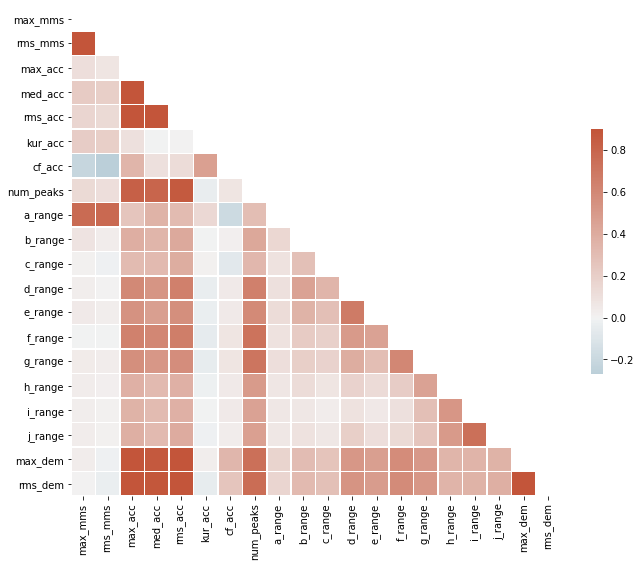

In [27]:
# Now we must check the correlation between variables

columns = ['max_mms', 'rms_mms', 'max_acc', 'med_acc',
       'rms_acc', 'kur_acc', 'cf_acc', 'num_peaks','a_range', 'b_range',
       'c_range','d_range', 'e_range', 'f_range', 'g_range', 'h_range',
       'i_range', 'j_range', 'max_dem', 'rms_dem',]


# Compute the correlation matrix
corr = diagnosis_cop[columns].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

As can be seen, some of the features are correlated, especially those associated with the same type of measurement (rms_mms with max_mms). This is to be expected, but we cannot discard the variables since it is very possible that in case of failure the maximum value is differentiating with respect to the rms value.

# Feature Engineering

In this section will create features that may help in prediction. Previously we are going to export the dataframe that we will need to put the model in production.

In [28]:
diagnosis_cop.to_csv('Data/diagnosis_model.csv')

In [29]:
# We add a feature called "prev_diag". This
# feature is the previous diagnosis of the machine. Normally machines
# are in the same status until the failure appears.

diagnosis_cop.index = diagnosis_cop.time
diagnosis_cop.drop(columns='time', inplace=True)
diagnosis_cop['prev_diag'] = diagnosis_cop.groupby(['machine','point'])['Id_Estado_Activo'].shift(fill_value=1)

In [30]:
# Now we create the feature 'pct_change_acc' and 'mean_mms_prev'. This feature
# is calculated using pct_change method. If a failure is presented
# normaly increases vibration amplitudes.

diagnosis_cop['pct_change_acc'] = diagnosis_cop.groupby(['machine','point']).max_acc.pct_change(fill_method='ffill' )
diagnosis_cop['mean_mms_prev'] = diagnosis_cop.groupby(['machine', 'point'])['rms_mms'].apply(lambda x: x.shift().expanding().mean())
diagnosis_cop['mean_mms_prev'] = diagnosis_cop['mean_mms_prev']/diagnosis_cop['rms_mms']
diagnosis_cop = diagnosis_cop.fillna(0)

In [31]:
# We create the feature "element_type". This feature will set
# if the element is a fan or a motor. The information can
# be extracted from the column "point"

diagnosis_cop['element_type'] = diagnosis_cop['point'][0:1] 
diagnosis_cop.loc[:, 'element_type'] = diagnosis_cop.point.map(lambda x: x[0])

<br>
Finally we have these features

<table style="width:50%">
  <tr>
    <th>Feature</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>max_mms</td>
    <td>Maximun level of vibration of mm/s waveform</td>
  </tr>
  <tr>
    <td>rms_mms</td>
    <td>RMS level of vibration of mm/s waveform</td>
  </tr>
  <tr>
    <td>max_acc</td>
    <td>Maximun level of vibration of acceleration waveform</td>
  </tr>
  <tr>
    <td>med_acc</td>
    <td>Medium level of vibration of acceleration waveform</td>
  </tr>
  <tr>
    <td>rms_acc</td>
    <td>RMS level of vibration of acceleration waveform</td>
  </tr>
  <tr>
    <td>kur_acc</td>
    <td>Kurtosis of acceleration waveform</td>
  </tr>
  <tr>
    <td>cf_acc</td>
    <td>Crest Factor level of vibration of acceleration waveform</td>
  </tr>
   <tr>
    <td>num_peaks</td>
    <td>Number of peaks in acceleration spectrum.</td>
  </tr>
  <tr>
    <td>a_range... j_range</td>
    <td>Amplitude of peaks in spectrum separated in ranges of 500Hz</td>
  </tr>
  <tr>
  <td>max_dem</td>
  <td>Maximun level of vibration of demodulation waveform</td>
  </tr>
  <tr>
    <td>rms_dem</td>
    <td>Medium level of vibration of demodulation waveform</td>
  </tr>
  <tr>
    <td>prev_diag</td>
    <td>Previous diagnosis</td>
  </tr>
  <tr>
    <td>pct_change_acc</td>
    <td>Percentage in change in acceleration</td>
  </tr>
  <tr>
    <td>mean_mms_prev</td>
    <td>Percentage in change in acceleration</td>
  </tr>
  <tr>
    <td>element_type</td>
    <td>Type of element, motor or fan</td>
  </tr>
</table>

# Model Creation

Now is time to create our model! We are going to start by spltiting our data into Train and Test groups as usual. Before that we apply a Scaler preprocessing to assure our data is well balanced.

In [32]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

merged_diagnostic_predict = diagnosis_cop.dropna().sort_index()
merged_diagnostic_predict['Id_Estado_Activo_fixed'] = merged_diagnostic_predict['Id_Estado_Activo_fixed'].astype('int')
merged_diagnostic_predict['prev_diag'] = merged_diagnostic_predict['prev_diag'].astype('int')

# We set the Good status as 0 label and Warning and Alarm as label 1.
merged_diagnostic_predict['prev_diag'] = merged_diagnostic_predict['prev_diag'].replace({1:0, 2:1, 3:1})
merged_diagnostic_predict['Id_Estado_Activo_fixed'] = merged_diagnostic_predict['Id_Estado_Activo_fixed'].replace({1:0, 2:1, 3:1})

In [33]:
merged_diagnostic_predict[merged_diagnostic_predict.index=="2020-07-09 11:14:30.214"]

,machine,point,max_mms,rms_mms,max_acc,med_acc,rms_acc,kur_acc,cf_acc,num_peaks,a_range,b_range,c_range,d_range,e_range,f_range,g_range,h_range,i_range,j_range,max_dem,rms_dem,Nombre,diagnostico,Id_Estado_Activo,Id_Estado_Activo_fixed,prev_diag,pct_change_acc,mean_mms_prev,element_type
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-09 11:14:30.214,S3-M38,V-LOA-V,8.3984,3.2096,3.3911,0.827969,0.855682,0.070801,3.963036,11.0,0.19525,0.09161,0.13109,0.40063,0.0,0.38564,0.46301,0.0,0.0,0.0,3.4925,1.455366,S3-Ventilador M38,Motor: Activo en buen estado.\n Ventilador: S...,3.0,1,1,0.316727,0.960943,V


In [34]:
# We create a column transformer object to scale numerical features and One Hot Encoder to
# fit categorical features.

col_names = ['max_mms', 'rms_mms', 'max_acc', 'med_acc',
             'rms_acc', 'kur_acc', 'cf_acc', 'num_peaks', 'max_dem', 'rms_dem','pct_change_acc',
             'a_range', 'b_range', 'c_range', 'd_range', 'e_range', 'f_range', 'g_range', 'h_range',
             'i_range', 'j_range', 'mean_mms_prev', 'element_type', 'prev_diag']


# We use ColumnTransformer method to apply scaling and One Hot in just one step.
ct = ColumnTransformer(
        [("scaling", PowerTransformer(), col_names[:-2]),
        ("onehot", OneHotEncoder(sparse=False), col_names[-2:])])


# We get all features
features = merged_diagnostic_predict.copy()
features = features[col_names]


# Train size is all data before last inspection. The data from last
# inspection will be use as test data.
last_inspection = datetime.datetime.strptime("2020-10-01", '%Y-%m-%d')
train_size = len(merged_diagnostic_predict[merged_diagnostic_predict.index < last_inspection])

X_train, X_test, y_train, y_test = train_test_split(features, merged_diagnostic_predict.Id_Estado_Activo_fixed, 
                                                    random_state=0, shuffle=False, train_size=train_size)


# Now we fit ct to train data and transform train and test data
ct.fit(X_train)
X_train = ct.transform(X_train)
X_test = ct.transform(X_test)

We have train and test data. Now we must create some models and compare them to find the best suited model to our data. We have a Classification problem, so the most used classifiers models are selected



CONFUSION MATRIX AND ROC CURVES
 



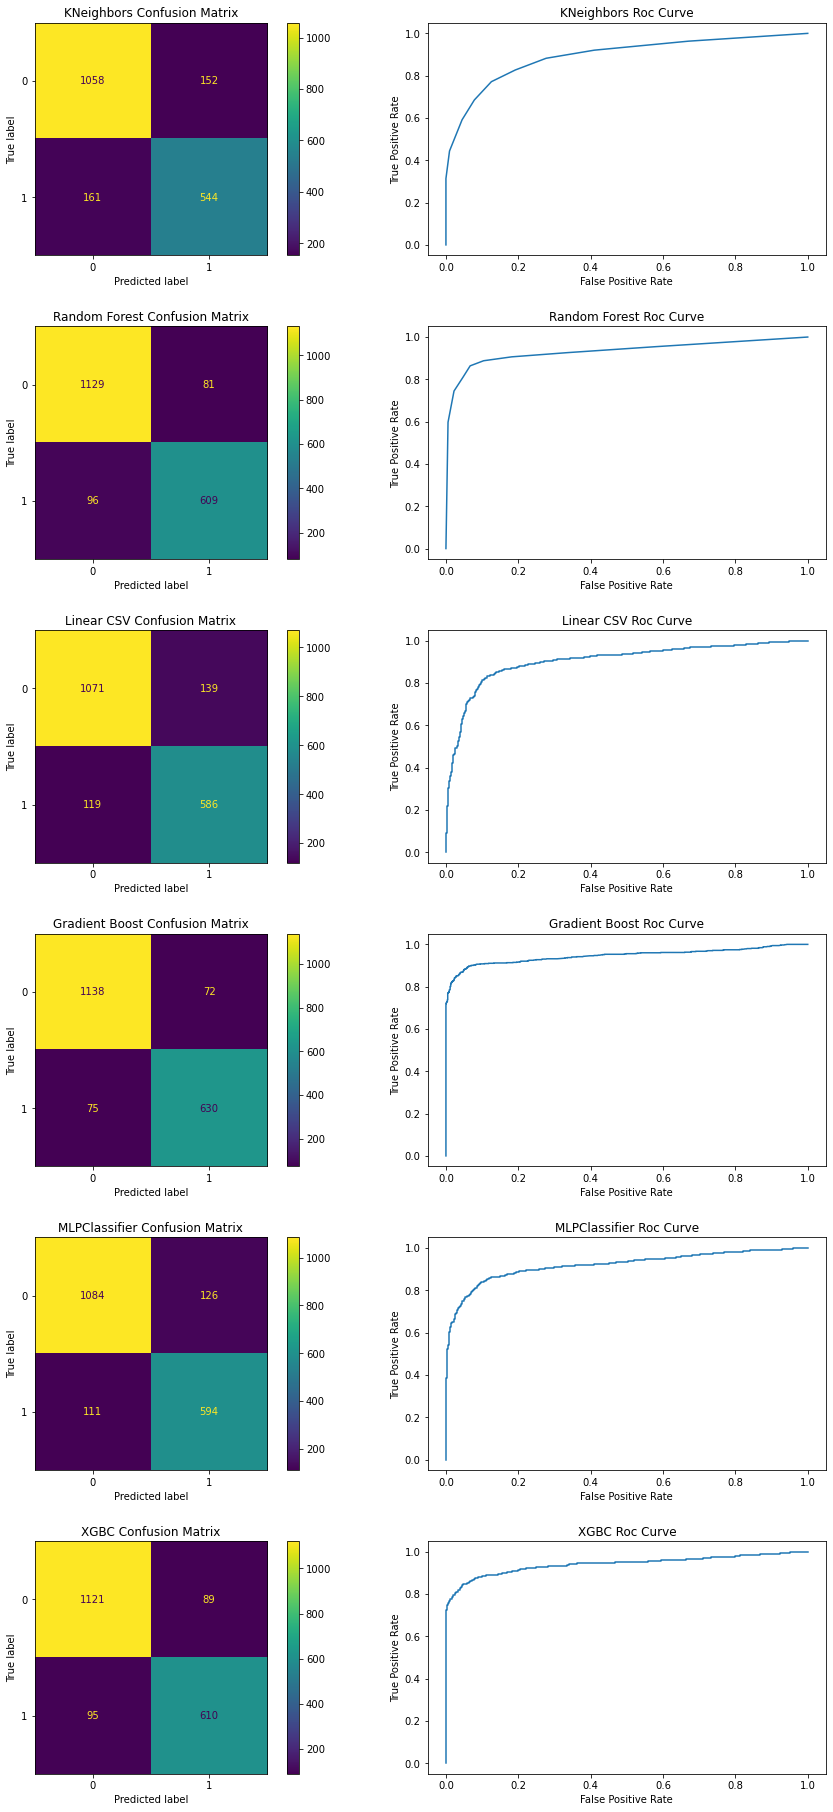

In [35]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import precision_recall_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Dict with the classifiers we are going to use
classifiers = {"KNeighbors": "KNeighborsClassifier", "Random Forest": "RandomForestClassifier",
              "Linear CSV": "LinearSVC", "MLP": "MLPClassifier",
               "Gradient Boost": "GradientBoostingClassifier", "XGBC": "XGBClassifier"}

# A dataframe to save the scores of each classifier
scores = pd.DataFrame(columns=["classifier","accuracy", "f1_score", "precision", "recall"])


# Create a function to evaluate the models
def evaluate_models(scores, X_train, y_train, y_test, classifier):
    """ With scores dataframe, data and the classifier the function
    return the dataframe with new metrics"""
    
    y_pred = classifier.predict(X_test)
    classifier_name = classifier.__class__.__name__
    
    
    if classifier_name == "LinearSVC":
        y_score = classifier.decision_function(X_test)
    else:
        y_score = classifier.predict_proba(X_test)
    
    
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    

                
    scores = scores.append({"classifier":classifier_name,
                  "accuracy": accuracy,
                  "f1_score": f1_score,
                  "precision": precision,
                  "recall": recall}, ignore_index=True)
    

    return y_pred, y_score, scores

    
print("\n\n========================================")
print("CONFUSION MATRIX AND ROC CURVES")
print("========================================\n \n")
fig, axes = plt.subplots(6,2 , figsize=(14,26))
fig.tight_layout(pad=5)
for key, value in classifiers.items():
    if value == "KNeighborsClassifier":        
        clf = KNeighborsClassifier(n_neighbors=9)
        clf.fit(X_train, y_train)
        
        
        y_pred, y_score, scores = evaluate_models(scores, X_train, y_train, y_test, clf)
        
        cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[0][0])
        plt.title('Confusion matrix of the classifier')
        fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[0][1])
        
        axes[0][0].set_title("{} Confusion Matrix".format(key))
        axes[0][1].set_title("{} Roc Curve".format(key))
        
    if value == "RandomForestClassifier":        
        forest = RandomForestClassifier(n_estimators=8, random_state=2)
        forest.fit(X_train, y_train)
        
        y_pred, y_score, scores = evaluate_models(scores, X_train, y_train, y_test, forest)
        
        cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[1][0])
        fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[1][1])
        
        axes[1][0].set_title("{} Confusion Matrix".format(key))
        axes[1][1].set_title("{} Roc Curve".format(key))

    
    if value == "LinearSVC":        
        linearCSV = LinearSVC(dual=False)
        linearCSV.fit(X_train, y_train)

        y_pred, y_score, scores = evaluate_models(scores, X_train, y_train, y_test, linearCSV)
        
        cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[2][0])
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[2][1])
        
        axes[2][0].set_title("{} Confusion Matrix".format(key))
        axes[2][1].set_title("{} Roc Curve".format(key))
    
    if value == "GradientBoostingClassifier":
        gbrt = GradientBoostingClassifier()
        gbrt.fit(X_train, y_train)
        
        y_pred, y_score, scores = evaluate_models(scores, X_train, y_train, y_test, gbrt)
        
        cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[3][0])
        fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[3][1])
        
        axes[3][0].set_title("{} Confusion Matrix".format(key))
        axes[3][1].set_title("{} Roc Curve".format(key))
    
    if value == "MLPClassifier":
        mlp = MLPClassifier(max_iter=2000, activation= 'tanh',
                    alpha= 0.0001, hidden_layer_sizes=(100,),
                    learning_rate='adaptive',
                    solver= 'adam')
        mlp.fit(X_train, y_train)
        
        y_pred, y_score, scores = evaluate_models(scores, X_train, y_train, y_test, mlp)
        
        cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[4][0])
        fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[4][1])
        
        axes[4][0].set_title("{} Confusion Matrix".format(value))
        axes[4][1].set_title("{} Roc Curve".format(value))
        
    
    if value == "XGBClassifier":
        xgbc = XGBClassifier(use_label_encoder=False, verbosity=0)
        xgbc.fit(X_train, y_train)

        y_pred, y_score, scores = evaluate_models(scores, X_train, y_train, y_test, xgbc)

        cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[5][0])
        fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[5][1])
        
        
        axes[5][0].set_title("{} Confusion Matrix".format(key))
        axes[5][1].set_title("{} Roc Curve".format(key))        

Confusion matrix and ROC curves points to GBC to be the best model. Let see the metrics

,classifier,accuracy,f1_score,precision,recall
0,KNeighborsClassifier,0.836554,0.776588,0.781609,0.771631
1,RandomForestClassifier,0.907572,0.873118,0.882609,0.863830
2,LinearSVC,0.865274,0.819580,0.808276,0.831206
3,MLPClassifier,0.876240,0.833684,0.825000,0.842553
4,GradientBoostingClassifier,0.923238,0.895522,0.897436,0.893617
5,XGBClassifier,0.903916,0.868946,0.872675,0.865248


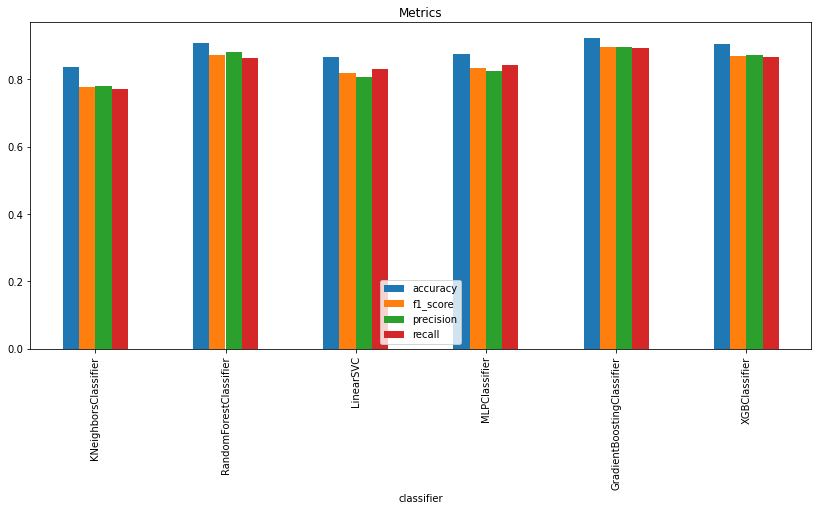

In [37]:
scores.plot(kind="bar", x="classifier",
            figsize=(14,6), title="Metrics");
scores

With all this data on the table we are going to choose GBC as our best classifier. 



# Gradient Boost Parameters

Let us now study the algorithm and analyze the parameters to see how they affect the results.

In [38]:
%%time
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D

all_train_results = []
all_test_results = []
parameters = []
parameters_values = []

# Learning Rate

learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

all_train_results.append(train_results)
all_test_results.append(test_results)
parameters.append("Learning rate")
parameters_values.append(learning_rates)
    
    
# N estimators

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100]
train_results = []
test_results = []
for estimator in n_estimators:
   model = GradientBoostingClassifier(n_estimators=estimator)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    

all_train_results.append(train_results)
all_test_results.append(test_results)
parameters.append("N stimators")
parameters_values.append(n_estimators)

# Max depths

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   model = GradientBoostingClassifier(max_depth=max_depth)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
all_train_results.append(train_results)
all_test_results.append(test_results)
parameters.append("Max depths")
parameters_values.append(max_depths)


# Min samples splits

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   model = GradientBoostingClassifier(min_samples_split=min_samples_split)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
all_train_results.append(train_results)
all_test_results.append(test_results)
parameters.append("Min samples split")
parameters_values.append(min_samples_splits)


# Min samples leaf

min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    

all_train_results.append(train_results)
all_test_results.append(test_results)
parameters.append("Min samples leaf")
parameters_values.append(min_samples_leafs)


# Max features

max_features = list(range(1,features.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   model = GradientBoostingClassifier(max_features=max_feature)
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

all_train_results.append(train_results)
all_test_results.append(test_results)
parameters.append("Max features")
parameters_values.append(max_features)

CPU times: user 3min 30s, sys: 427 ms, total: 3min 31s
Wall time: 3min 31s


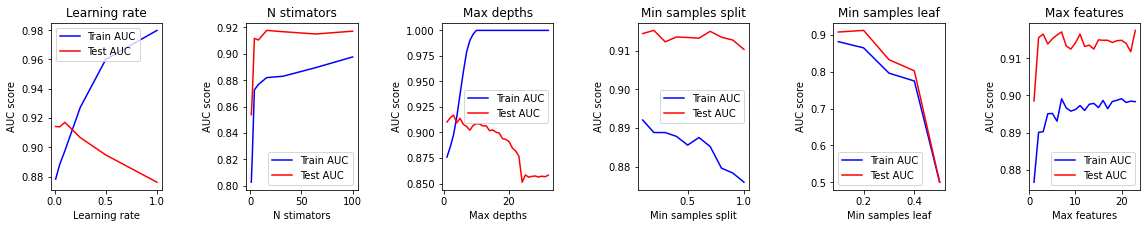

In [39]:
fig, axes = plt.subplots(1,6 , figsize=(17,4))
fig.tight_layout(pad=5)

for index, axe in enumerate(axes):
    axe.set_title(parameters[index])
    axe.plot(parameters_values[index], all_train_results[index], 'b', label='Train AUC')
    axe.plot(parameters_values[index], all_test_results[index], 'r', label='Test AUC')
    axe.legend()
    axe.set_ylabel('AUC score')
    axe.set_xlabel(parameters[index])
    

plt.show()

With this information we are going to go into a GridSearch with paramerts we may thin will improve our results. We are going to use n_estimators, max_depth and learning_rate.

In [40]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

parameters = {
    "n_estimators":[5,50,100],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.05,0.1]
}

precision_scorer = metrics.make_scorer(metrics.precision_score,
                                       zero_division=0)

custom_scoring = {'precision':precision_scorer}

cv = GridSearchCV(gbrt,parameters, scoring = 'accuracy',
                  verbose=1, cv=StratifiedKFold(n_splits=10),
                  refit=False)

cv.fit(X_train,y_train)

Fitting 10 folds for each of 45 candidates, totalling 450 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [5, 50, 100]},
             refit=False, scoring='accuracy', verbose=1)

In [41]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [42]:
display(cv)

Best parameters are: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}


0.547 + or -0.001 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 5}
0.821 + or -0.064 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.821 + or -0.064 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 100}
0.547 + or -0.001 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
0.87 + or -0.042 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.871 + or -0.041 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.547 + or -0.001 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
0.883 + or -0.04 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.879 + or -0.038 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
0.547 + or -0.001 for the {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 5}
0.87 + or -0.038 for the {'learning_rate': 0.01, 'max_depth'



METRICS FOR OPTIMIZED CLASSIFIER
Accuracy: 0.9227154046997389 
F1_score: 0.8951841359773371 
Precision: 0.8939179632248939 
Recall: 0.8964539007092198 
AUC: 0.9451626516616846 
 



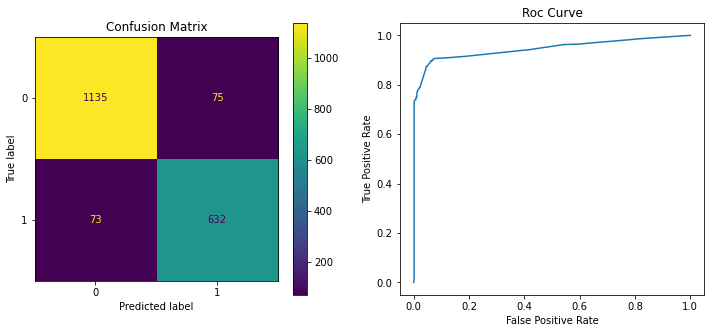

In [79]:
#We use the best parameters to optimize the Classifier

gbrt = GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                  n_estimators=50).fit(X_train, y_train)
y_pred = gbrt.predict(X_test)
y_score = gbrt.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:, 1])

print("\n\n========================================")
print("METRICS FOR OPTIMIZED CLASSIFIER")
print("Accuracy: {} \nF1_score: {} \nPrecision: {} \nRecall: {} \nAUC: {} ".format(metrics.accuracy_score(y_test, y_pred),
                                                                           metrics.f1_score(y_test, y_pred),
                                                                           metrics.precision_score(y_test, y_pred),
                                                                           metrics.recall_score(y_test, y_pred),
                                                                           metrics.auc(fpr, tpr)))
print("========================================\n \n")

fig, axes = plt.subplots(1,2 , figsize=(12,5))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[0])
axes[0].set_title('Confusion Matrix')
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[1])
axes[1].set_title('Roc Curve')
plt.show()

# Final Tuning
It is time to choose our decision threshold. In our case we prefer to keep the ones that are really positive, since we do not want to waste time analyzing machinery in good condition or that present failures in an incipient state. 


Accuracy: 0.9248041775456919 
F1_score: 0.8938053097345132 
Precision: 0.9308755760368663 
Recall: 0.8595744680851064 
AUC: 0.9411312349803647 


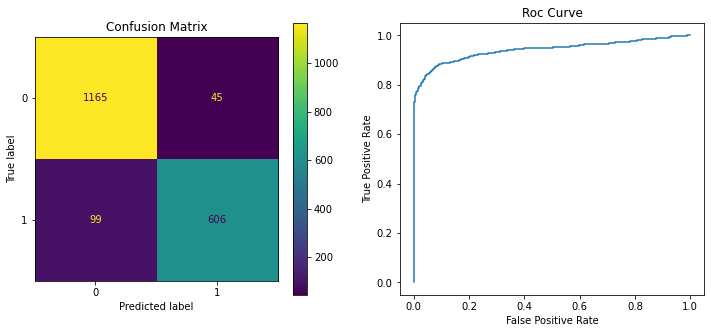

In [46]:
threshold = 0.65

y_pred = (gbrt.predict_proba(X_test)[:,1] >= threshold).astype(bool)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:, 1])

print("\n========================================")
print("Accuracy: {} \nF1_score: {} \nPrecision: {} \nRecall: {} \nAUC: {} ".format(metrics.accuracy_score(y_test, y_pred),
                                                                           metrics.f1_score(y_test, y_pred),
                                                                           metrics.precision_score(y_test, y_pred),
                                                                           metrics.recall_score(y_test, y_pred),
                                                                           metrics.auc(fpr, tpr)))
print("========================================")

fig, axes = plt.subplots(1,2 , figsize=(12,5))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[0])
axes[0].set_title('Confusion Matrix')
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[1])
axes[1].set_title('Roc Curve')
plt.show()

In [102]:
# We can export the column transformer and model object for later application to new data

from pickle import dump

ct_filename = 'Model/ct.pkl'
model_filename = 'Model/gcbmodel.sav'

dump(ct, open(ct_filename, 'wb'))
dump(gbrt, open(model_filename, 'wb'))

Now is time to save our results and upload to a file in Amazon's S3 service. After that we can check the result at:
<a href="https://projectargus.herokuapp.com/ma_results">Project Argus</a>